In [246]:
# THIS VERSION IS FOR PYTHON 2 #
import urllib2
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ochl
import matplotlib
import pylab
from pandas import Series


In [247]:

params = {'axes.labelsize': 18,'axes.titlesize':20, 'text.fontsize': 20, 'legend.fontsize': 20, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
matplotlib.rcParams.update(params)
%matplotlib inline

In [248]:
def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [249]:
def movingaverage(values,window):
    weigths = np.repeat(1.0, window)/window
    smas = np.convolve(values, weigths, 'valid')
    return smas # as a numpy array



In [205]:
# wrong calculation?
#def ExpMovingAverage(values, window):
#    if len(values) < 2 * window:
#        raise ValueError("data is too short")
#    weights = np.exp(np.linspace(-1., 0., window))
#    weights /= weights.sum()
#    a =  np.convolve(values, weights, mode='full')[:len(values)]
#    a[:window] = a[window]
#    return a

In [250]:
def ExpMovingAverage(seriesp, window):
    ema=seriesp.ewm(span=window).mean().values
    ema[:window] = ema[window]
    return ema


In [136]:
# another method to calculate ema
#def ExpMovingAverage(data, window):
#    if len(data) < 2 * window:
#        raise ValueError("data is too short")
#    c = 2.0 / (window + 1)
#    current_ema = movingaverage(data[-window*2:-window], window)
#    for value in data[-window:]:
#        current_ema = (c * value) + ((1 - c) * current_ema)
#    return current_ema

In [229]:
# The original one, with data array
def computeMACD0(x, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow


In [251]:
def computeMACD(seriesp, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(seriesp, slow)
    emafast = ExpMovingAverage(seriesp, fast)
    return emaslow, emafast, emafast - emaslow


In [282]:

def graphData(stock,MA1,MA2):
    '''
        Use this to dynamically pull a stock:
    '''
    try:
        print 'Currently Pulling',stock
        print str(datetime.datetime.fromtimestamp(int(time.time())).strftime('%Y-%m-%d %H:%M:%S'))
        urlToVisit = 'http://chartapi.finance.yahoo.com/instrument/1.0/'+stock+'/chartdata;type=quote;range=1y/csv'
        stockFile =[]
        try:
            sourceCode = urllib2.urlopen(urlToVisit).read()
            splitSource = sourceCode.split('\n')
            for eachLine in splitSource:
                splitLine = eachLine.split(',')
                if len(splitLine)==6:
                    if 'values' not in eachLine:
                        stockFile.append(eachLine)
        except Exception, e:
            print str(e), 'failed to organize pulled data.'
    except Exception,e:
        print str(e), 'failed to pull pricing data'
    try:   
        date, closep, highp, lowp, openp, volume = np.loadtxt(stockFile,delimiter=',', unpack=True,
                                                              converters={ 0: mdates.strpdate2num('%Y%m%d')})
        x = 0
        y = len(date)
        newAr = []
        while x < y:
            appendLine = date[x],openp[x],closep[x],highp[x],lowp[x],volume[x]
            newAr.append(appendLine)
            x+=1
            
        Av1 = movingaverage(closep, MA1)
        Av2 = movingaverage(closep, MA2)

        SP = len(date[MA2-1:])
            
        fig = plt.figure(facecolor='#07000d', figsize=(16,12))

        ax1 = plt.subplot2grid((8,6), (2,0), rowspan=4, colspan=4, axisbg='#07000d')
        candlestick_ochl(ax1, newAr[-SP:], width=.6, colorup='#53c156', colordown='#ff1717')

        Label1 = str(MA1)+' SMA'
        Label2 = str(MA2)+' SMA'

        ax1.plot(date[-SP:],Av1[-SP:],'#e1edf9',label=Label1, linewidth=1.5)
        ax1.plot(date[-SP:],Av2[-SP:],'#4ee6fd',label=Label2, linewidth=1.5)
        
        ax1.grid(True, color='w')
        ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.yaxis.label.set_color("w")
        ax1.spines['bottom'].set_color("#5998ff")
        ax1.spines['top'].set_color("#5998ff")
        ax1.spines['left'].set_color("#5998ff")
        ax1.spines['right'].set_color("#5998ff")
        ax1.tick_params(axis='y', colors='w')
        plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
        ax1.tick_params(axis='x', colors='w')
        plt.ylabel('Stock price')

        maLeg = plt.legend(loc=9, ncol=2, prop={'size':16},
                   fancybox=True, borderaxespad=0.)
        maLeg.get_frame().set_alpha(0.4)
        textEd = pylab.gca().get_legend().get_texts()
        pylab.setp(textEd[0:5], color = 'w')

        volumeMin = 0
        
        ax0 = plt.subplot2grid((8,6), (6,0), sharex=ax1, rowspan=2, colspan=4, axisbg='#07000d')
        rsi = rsiFunc(closep)
        rsiCol = '#c1f9f7'
        posCol = '#386d13'
        negCol = '#8f2020'
        
        ax0.plot(date[-SP:], rsi[-SP:], rsiCol, linewidth=1.5)
        ax0.axhline(70, color=negCol)
        ax0.axhline(30, color=posCol)
        ax0.axhline(50, color=rsiCol)
        ax0.fill_between(date[-SP:], rsi[-SP:], 70, where=(rsi[-SP:]>=70), facecolor=negCol, edgecolor=negCol, alpha=1)
        ax0.fill_between(date[-SP:], rsi[-SP:], 30, where=(rsi[-SP:]<=30), facecolor=posCol, edgecolor=posCol, alpha=1)
        ax0.set_yticks([30,50,70])
        ax0.yaxis.label.set_color("w")
        ax0.spines['bottom'].set_color("#5998ff")
        ax0.spines['top'].set_color("#5998ff")
        ax0.spines['left'].set_color("#5998ff")
        ax0.spines['right'].set_color("#5998ff")
        ax0.tick_params(axis='y', colors='w')
        ax0.tick_params(axis='x', colors='w')
        plt.ylabel('RSI')

        ax1v = ax1.twinx()
        ax1v.fill_between(date[-SP:],volumeMin, volume[-SP:], facecolor='#00ffe8', alpha=.35)
        ax1v.axes.yaxis.set_ticklabels([])
        ax1v.grid(False)
        ###Edit this to 3, so it's a bit larger
        ax1v.set_ylim(0, 3*volume.max())
        ax1v.spines['bottom'].set_color("#5998ff")
        ax1v.spines['top'].set_color("#5998ff")
        ax1v.spines['left'].set_color("#5998ff")
        ax1v.spines['right'].set_color("#5998ff")
        ax1v.tick_params(axis='x', colors='w')
        ax1v.tick_params(axis='y', colors='w')
        ax2 = plt.subplot2grid((8,6), (0,0), sharex=ax1, rowspan=2, colspan=4, axisbg='#07000d')
        fillcolor = '#00ffe8'
        nslow = 26
        nfast = 12
        nema = 9
        
        emaslow, emafast, macd = computeMACD(Series(closep,date))
        ema9 = ExpMovingAverage(Series(macd,date), nema)
        ax2.plot(date[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
        ax2.plot(date[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
        ax2.fill_between(date[-SP:], macd[-SP:]-ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)

        plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
        ax2.spines['bottom'].set_color("#5998ff")
        ax2.spines['top'].set_color("#5998ff")
        ax2.spines['left'].set_color("#5998ff")
        ax2.spines['right'].set_color("#5998ff")
        ax2.tick_params(axis='x', colors='w')
        ax2.tick_params(axis='y', colors='w')
        plt.ylabel('MACD', color='w')
        ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
        for label in ax0.xaxis.get_ticklabels():
            label.set_rotation(45)

        plt.suptitle(stock.upper(), x=0.37, color='w', fontsize=20)

        plt.setp(ax0.get_xticklabels(), visible=True)
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)
        
# text annotation omitted here
#        ax1.annotate('Big news!',(date[510],Av1[510]),
#            xytext=(0.8, 0.9), textcoords='axes fraction',
#            arrowprops=dict(facecolor='white', shrink=0.05),
#            fontsize=14, color = 'w',
#            horizontalalignment='right', verticalalignment='bottom')

        plt.subplots_adjust(left=.09, bottom=.14, right=.94, top=.95, wspace=.20, hspace=0)
        plt.show()
        fig.savefig('example.png',facecolor=fig.get_facecolor())
           
    except Exception,e:
        print 'main loop',str(e)


Currently Pulling qqq
2016-06-26 18:11:46


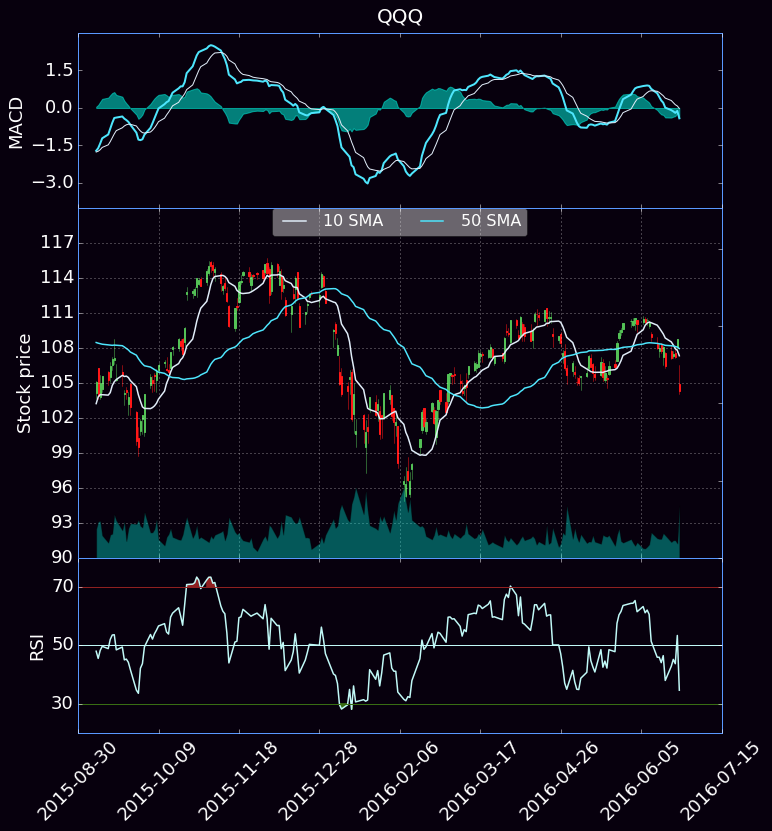

In [286]:
graphData('qqq',10,50)

In [178]:
# Test and extract data from each function

print str(datetime.datetime.fromtimestamp(int(time.time())).strftime('%Y-%m-%d %H:%M:%S'))
urlToVisit = 'http://chartapi.finance.yahoo.com/instrument/1.0/'+'SPY'+'/chartdata;type=quote;range=1y/csv'
stockFile =[]
sourceCode = urllib2.urlopen(urlToVisit).read()
splitSource = sourceCode.split('\n')
for eachLine in splitSource:
    splitLine = eachLine.split(',')
    if len(splitLine)==6:
        if 'values' not in eachLine:
            stockFile.append(eachLine)
            
            
date, closep, highp, lowp, openp, volume = np.loadtxt(stockFile,delimiter=',', unpack=True,
                                                              converters={ 0: mdates.strpdate2num('%Y%m%d')})
x = 0
y = len(date)
newAr = []
while x < y:
    appendLine = date[x],openp[x],closep[x],highp[x],lowp[x],volume[x]
    newAr.append(appendLine)
    x+=1
            
nslow = 26
nfast = 12
nema = 9
Av1 = movingaverage(closep, 10)
Av2 = movingaverage(closep, 50)
rsi = rsiFunc(closep)
emaslow, emafast, macd = computeMACD(closep)
ema9 = ExpMovingAverage(macd, nema)
print date, closep

2016-06-25 22:53:49
[ 735778.  735779.  735780.  735781.  735785.  735786.  735787.  735788.
  735789.  735792.  735793.  735794.  735795.  735796.  735799.  735800.
  735801.  735802.  735803.  735806.  735807.  735808.  735809.  735810.
  735813.  735814.  735815.  735816.  735817.  735820.  735821.  735822.
  735823.  735824.  735827.  735828.  735829.  735830.  735831.  735834.
  735835.  735836.  735837.  735838.  735841.  735842.  735843.  735844.
  735845.  735849.  735850.  735851.  735852.  735855.  735856.  735857.
  735858.  735859.  735862.  735863.  735864.  735865.  735866.  735869.
  735870.  735871.  735872.  735873.  735876.  735877.  735878.  735879.
  735880.  735883.  735884.  735885.  735886.  735887.  735890.  735891.
  735892.  735893.  735894.  735897.  735898.  735899.  735900.  735901.
  735904.  735905.  735906.  735907.  735908.  735911.  735912.  735913.
  735914.  735915.  735918.  735919.  735920.  735921.  735922.  735925.
  735926.  735927.  735929.  73

In [254]:
closepS = Series(closep,date)
ema50=closepS.ewm(span=50).mean().values



In [164]:
# another method to calculate ema
def ema(data, window):
    if len(data) < 2 * window:
        raise ValueError("data is too short")
    c = 2.0 / (window + 1)
    current_ema = movingaverage(data[-window*2:-window], window)
    for value in data[-window:]:
        current_ema = (c * value) + ((1 - c) * current_ema)
    print current_ema